In [341]:
## Imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import upf_to_json 

## Another option is to use xmltodict and do much of the conversion myself.  Not sure which is better...

# import xmltodict
# XMLfile="/Users/nathanvaughn/Desktop/sg15_oncv_xml_2018-06-25/Mg_ONCV_PBE-1.2.xml"
# xml_str = open(XMLfile, 'r').read()
# xdict = xmltodict.parse(xml_str)
# psp = xdict['fpmd:species']['norm_conserving_semilocal_pseudopotential']
# psp.keys()
# strlist = psp['local_potential']['#text'].split()
# psp['local_potential']['f_local_potential'] = np.zeros(len(strlist))
# for i in range(len(strlist)):
#     psp['local_potential']['f_local_potential'][i] = float(psp['local_potential']['#text'].split()[i])
# psp['local_potential']['f_local_potential'][0]
## and so on....



atomicNumber=83
pspFile  = "/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/"+str(atomicNumber)+"_ONCV_PBE-1.0.upf"
# pspFile  = "/Users/nathanvaughn/Desktop/N_ONCV_PBE-1.0.upf"
upf_str = open(pspFile, 'r').read()


In [342]:
psp_temp = upf_to_json.upf_to_json(upf_str, pspFile)
psp = psp_temp['pseudo_potential']

In [343]:
# psp.keys()
psp.items();

In [344]:
print(type(psp))
print(psp.keys())

<class 'dict'>
dict_keys(['header', 'radial_grid', 'local_potential', 'beta_projectors', 'D_ion', 'atomic_wave_functions', 'total_charge_density'])


In [345]:
psp['header']

{'number_of_proj': 8,
 'core_correction': False,
 'element': 'Bi',
 'pseudo_type': 'NC',
 'z_valence': 15.0,
 'mesh_size': 602,
 'is_ultrasoft': False,
 'number_of_wfc': 0,
 'spin_orbit': False,
 'original_upf_file': '/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/83_ONCV_PBE-1.0.upf'}

In [346]:
print(type(psp['radial_grid']))
print(type(psp['local_potential']))
print(type(psp['beta_projectors']))
print(type(psp['D_ion']))
print(type(psp['atomic_wave_functions']))
print(type(psp['total_charge_density']))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [347]:
type(psp['header']['z_valence'])

float

In [348]:
psp['local_potential'];
for i in range(psp['header']['number_of_proj']):
    print("beta projector %i, angular momentum=%i." %(i,psp['beta_projectors'][i]['angular_momentum']))
    print(len(psp['beta_projectors'][i]['radial_function']))
    
# psp['beta_projectors'][0]

beta projector 0, angular momentum=0.
372
beta projector 1, angular momentum=0.
372
beta projector 2, angular momentum=1.
372
beta projector 3, angular momentum=1.
372
beta projector 4, angular momentum=2.
372
beta projector 5, angular momentum=2.
372
beta projector 6, angular momentum=3.
372
beta projector 7, angular momentum=3.
372


[0.   0.01 0.02 0.03 0.04]
[0.08464768 0.08376544 0.08289218 0.0820278 ]


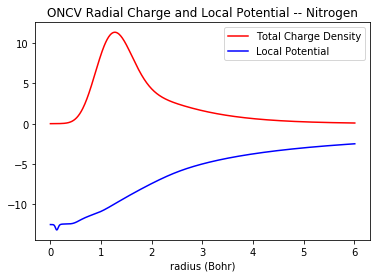

In [350]:
r = np.array(psp['radial_grid'])
print(r[0:5])
density = np.array(psp['total_charge_density'])
print(density[-5:-1])
local_potential = psp['local_potential']

plt.figure()
plt.title("ONCV Radial Charge and Local Potential -- Nitrogen")
plt.plot(r,density,'r-', label='Total Charge Density')
plt.plot(r,local_potential,'b-',label='Local Potential')
plt.xlabel('radius (Bohr)')
plt.legend()
plt.show()

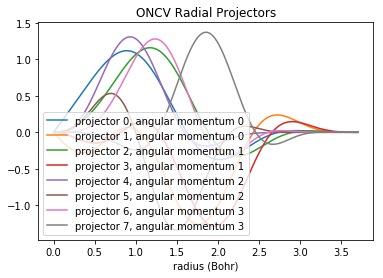

In [253]:
r = np.array(psp['radial_grid'])

# beta(i): projector riβ(ri) (note the factor r!)

plt.figure()
plt.title("ONCV Radial Projectors")
plt.xlabel('radius (Bohr)')
for i in range(psp['header']['number_of_proj']):
    length = len(psp['beta_projectors'][i]['radial_function'])
    projector = np.array(psp['beta_projectors'][i]['radial_function'])
    plt.plot(r[:length],psp['beta_projectors'][i]['radial_function'], label="projector %i, angular momentum %i" %(i,psp['beta_projectors'][i]['angular_momentum']))
#     plt.plot(r[:length],psp['beta_projectors'][i]['radial_function']/r[:length], label="projector %i, angular momentum %i" %(i,psp['beta_projectors'][i]['angular_momentum']))
plt.legend()
plt.show()



In [255]:
psp['D_ion'];

In [430]:
'''
@author: nathanvaughn
'''
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import erf
import os


class ONCV_PSP(object):
    '''
    The ONCV Pseudopotential object.  Will contain the interpolators needed for the nonlocal potential,
    the density initialization, etc.
    '''
    def __init__(self,atomicNumber):
        '''
        PSP Constructor
        '''
        self.atomicNumber=atomicNumber
        pspFile = "/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/"+str(atomicNumber)+"_ONCV_PBE-1.0.upf"
        upf_str = open(pspFile, 'r').read()
        psp_temp = upf_to_json.upf_to_json(upf_str, pspFile)
        self.psp = psp_temp['pseudo_potential']
        self.setProjectorInterpolators()
        self.setDensityInterpolator()
        self.setLocalPotentialInterpolator()
        
    def setDensityInterpolator(self,verbose=0):
        r = np.array(self.psp['radial_grid'])
        density = np.array(self.psp['total_charge_density'])
        ## Is it okay to set the boundary condition to zero?  
        self.densityInterpolator = InterpolatedUnivariateSpline(r,density,k=3,ext='zeros')
        
    def evaluateDensityInterpolator(self,r):
        # if zeroes are okay for the extrapolation, then this is okay.  If not, then need to wrap in try/except.
        return self.densityInterpolator(r)
        
    def setLocalPotentialInterpolator(self,verbose=0):
        r = np.array(self.psp['radial_grid'])
        local_potential = np.array(self.psp['local_potential'])
        self.localPotentialInterpolator = InterpolatedUnivariateSpline(r,local_potential,k=3,ext='raise')
    
    def evaluateLocalPotentialInterpolator(self,r):
        nr=len(r)
        Vloc = np.zeros(nr)
        for i in range(nr):
            try:
                Vloc[i] = self.localPotentialInterpolator(r[i])
            except ValueError:
                Vloc[i] = -self.psp['header']['z_valence']/r[i]
        return Vloc
        
    def setProjectorInterpolators(self,verbose=0):
        
        self.projectorInterpolators = {}
        r = np.array(self.psp['radial_grid'])
        if verbose>0: 
            print("Number of porjectors: ", self.psp['header']['number_of_proj'])
            
        for i in range(self.psp['header']['number_of_proj']):
            
            if verbose>0: 
                print("Creating interpolator for projector %i with angular momentum %i" %(i,self.psp['beta_projectors'][i]['angular_momentum']))
            
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            
            self.projectorInterpolators[str(i)] = InterpolatedUnivariateSpline(r[:length_of_projector_data],proj,k=3,ext='zeros')
        return
    
    def evaluateProjectorInterpolator(self,idx,r):
        # if zeroes are okay for the extrapolation, then this is okay.  If not, then need to wrap in try/except.
        return self.projectorInterpolators[str(idx)](r)
   
    def plotProjectors(self):
        
        r = np.array(self.psp['radial_grid'])
        plt.figure()
        for i in range(self.psp['header']['number_of_proj']):
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            plt.plot(r[:length_of_projector_data], proj,'.',label="projector data %i" %i)
            plt.title("ONCV Projector Data")
            
            
        r = np.array(self.psp['radial_grid'])
        plt.figure()
        for i in range(self.psp['header']['number_of_proj']):
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            rmax = r[length_of_projector_data]
            
            rInterp = np.linspace(0,rmax,1000)
            plt.plot(rInterp,self.evaluateProjectorInterpolator(i,rInterp),label="projector %i" %i)
        plt.title("Projector Cubic Spline Interpolators")
#         plt.legend()
        
        plt.show()
        
    def plotDensity(self):
        r = np.array(self.psp['radial_grid'])
        density = np.array(self.psp['total_charge_density'])
        rInterp = np.linspace(0,2*r[-1],1000)
        plt.figure()
        plt.plot(r,density,'r.',label="ONCV Data")
        plt.plot(rInterp, self.evaluateDensityInterpolator(rInterp), 'b-', label="Interpolation")
        plt.legend()
        plt.title("Density")
        plt.show()
        
    def plotLocalPotential(self,ylims=[-1.2, -10, -100]):
        r = np.array(self.psp['radial_grid'])
        local_potential = np.array(self.psp['local_potential'])
        rInterp = np.linspace(1e-2,1.5*r[-1],5000)
        Vfarfield = -self.psp['header']['z_valence']/rInterp
        V_all_electron = -self.atomicNumber/rInterp
        VlocInterp = self.evaluateLocalPotentialInterpolator(rInterp)
        
        for ylimfactor in ylims:
            plt.figure()
            plt.plot(rInterp, V_all_electron, 'r-', label="-Z/r")
            plt.plot(rInterp, Vfarfield, 'g-', label="-Zvalence/r")
            plt.plot(r,local_potential,'c.',label="ONCV Data")
            plt.plot(rInterp, VlocInterp, 'b--', label="Interpolation")
            plt.legend()
            plt.title("Local Potential")
            plt.ylim([-ylimfactor*np.min(local_potential),2])
            plt.show()

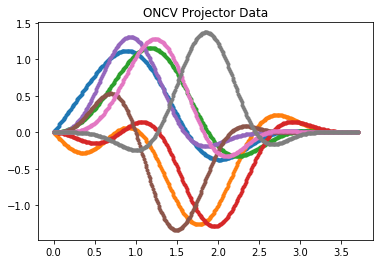

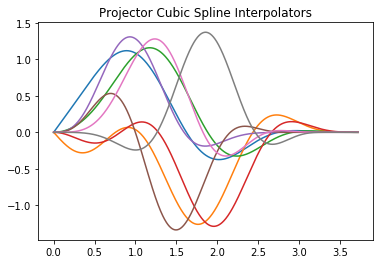

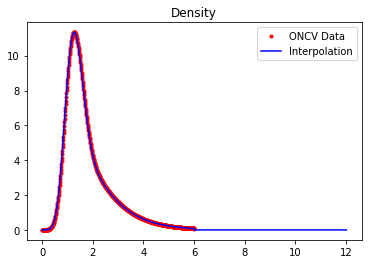

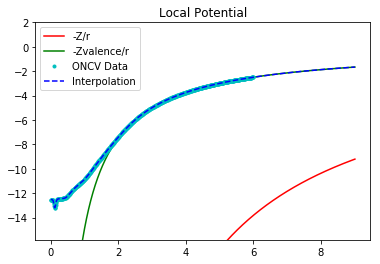

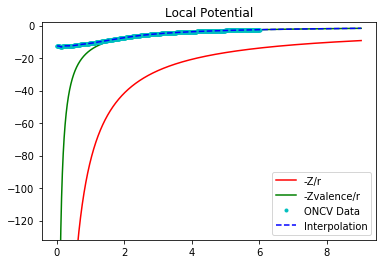

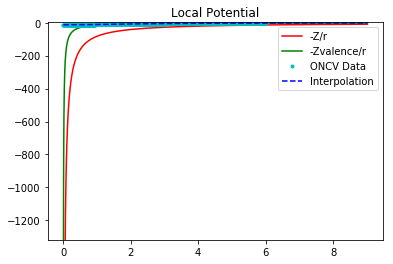

In [431]:
psp=None
proj=None
density=None
BismuthPSP = ONCV_PSP(83)
BismuthPSP.plotProjectors()
BismuthPSP.plotDensity()
BismuthPSP.plotLocalPotential()


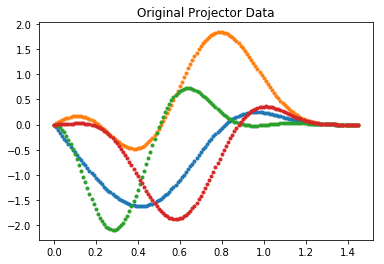

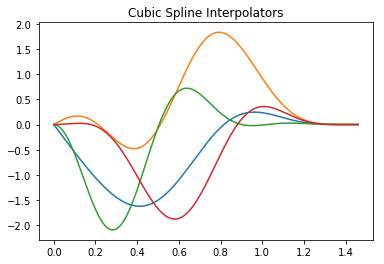

In [267]:
CarbonPSP = ONCV_PSP(6)
CarbonPSP.psp['header']
CarbonPSP.plotProjectorData()
CarbonPSP.plotProjectorInterpolators()

In [235]:
OxygenPSP = ONCV_PSP(8)
OxygenPSP.psp['header']

{'number_of_proj': 4,
 'core_correction': False,
 'element': 'O',
 'pseudo_type': 'NC',
 'z_valence': 6.0,
 'mesh_size': 602,
 'is_ultrasoft': False,
 'number_of_wfc': 0,
 'spin_orbit': False,
 'original_upf_file': '/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/8_ONCV_PBE-1.0.upf'}

In [181]:
BismuthPSP.psp['header']

{'number_of_proj': 8,
 'core_correction': False,
 'element': 'Bi',
 'pseudo_type': 'NC',
 'z_valence': 15.0,
 'mesh_size': 602,
 'is_ultrasoft': False,
 'number_of_wfc': 0,
 'spin_orbit': False,
 'original_upf_file': '/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/83_ONCV_PBE-1.0.upf'}